In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dermnet/test/Light Diseases and Disorders of Pigmentation/polymorphous-light-eruption-33.jpg
/kaggle/input/dermnet/test/Light Diseases and Disorders of Pigmentation/milia-11.jpg
/kaggle/input/dermnet/test/Light Diseases and Disorders of Pigmentation/pseudo-porphyria-2.jpg
/kaggle/input/dermnet/test/Light Diseases and Disorders of Pigmentation/sun-damaged-skin-12.jpg
/kaggle/input/dermnet/test/Light Diseases and Disorders of Pigmentation/phototoxic-reactions-72.jpg
/kaggle/input/dermnet/test/Light Diseases and Disorders of Pigmentation/melasma-34.jpg
/kaggle/input/dermnet/test/Light Diseases and Disorders of Pigmentation/vitiligo-4.jpg
/kaggle/input/dermnet/test/Light Diseases and Disorders of Pigmentation/milia-3.jpg
/kaggle/input/dermnet/test/Light Diseases and Disorders of Pigmentation/porphyrias-51.jpg
/kaggle/input/dermnet/test/Light Diseases and Disorders of Pigmentation/erythema-ab-igne-16.jpg
/kaggle/input/dermnet/test/Light Diseases and Disorders of Pigmentation/m

In [3]:
import os

for root, dirs, files in os.walk('/kaggle/input/dermnet'):
    level = root.replace('/kaggle/input/dermnet', '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    for d in dirs:
        print(f"{indent}    {d}/")
    # Only print the first couple of levels
    if level >= 2:
        continue


dermnet/
    test/
    train/
    test/
        Light Diseases and Disorders of Pigmentation/
        Lupus and other Connective Tissue diseases/
        Acne and Rosacea Photos/
        Systemic Disease/
        Poison Ivy Photos and other Contact Dermatitis/
        Vascular Tumors/
        Urticaria Hives/
        Atopic Dermatitis Photos/
        Bullous Disease Photos/
        Hair Loss Photos Alopecia and other Hair Diseases/
        Tinea Ringworm Candidiasis and other Fungal Infections/
        Psoriasis pictures Lichen Planus and related diseases/
        Melanoma Skin Cancer Nevi and Moles/
        Nail Fungus and other Nail Disease/
        Scabies Lyme Disease and other Infestations and Bites/
        Eczema Photos/
        Exanthems and Drug Eruptions/
        Herpes HPV and other STDs Photos/
        Seborrheic Keratoses and other Benign Tumors/
        Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions/
        Vasculitis Photos/
        Cellulitis Impeti

In [3]:
import os

root = '/kaggle/input/dermnet'
subset = 'train'
split_path = os.path.join(root, subset)

# 1. Scan once and pick only the first occurrence of each class
seen = set()
unique_class_dirs = []
for entry in os.scandir(split_path):
    if not entry.is_dir():
        continue
    cls = entry.name
    if cls in seen:
        continue
    seen.add(cls)
    unique_class_dirs.append(entry.path)

print(f"Found {len(unique_class_dirs)} unique classes (skipping duplicates).")

# 2. Now build your image‑stats DataFrame just from these unique dirs:
import cv2
import pandas as pd
from joblib import Parallel, delayed

def load_stats(img_path, cls_name):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    h, w = img.shape
    return {
        'class': cls_name,
        'height': h,
        'width': w,
        'aspect_ratio': w/h,
        'mean_intensity': img.mean(),
        'std_intensity': img.std()
    }

# Pre‑collect all file paths
tasks = []
for cls_dir in unique_class_dirs:
    cls_name = os.path.basename(cls_dir)
    for fname in os.listdir(cls_dir):
        tasks.append((os.path.join(cls_dir, fname), cls_name))

# 3. Parallel load + stats
records = Parallel(n_jobs=-1, backend='threading')(
    delayed(load_stats)(path, cls) for path, cls in tasks
)
# filter out bad reads
records = [r for r in records if r is not None]

df = pd.DataFrame.from_records(records)
print("Final stats DataFrame:", df.shape)


Found 23 unique classes (skipping duplicates).
Final stats DataFrame: (15557, 6)


=== IQR Outliers ===
height         : 3 outliers
width          : 4 outliers
aspect_ratio   : 0 outliers
mean_intensity : 55 outliers
std_intensity  : 30 outliers

=== Z‑score Outliers (>3σ) ===
height         : 8
width          : 3
aspect_ratio   : 0
mean_intensity : 15
std_intensity  : 23


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



=== IsolationForest Outliers (156 flagged) ===


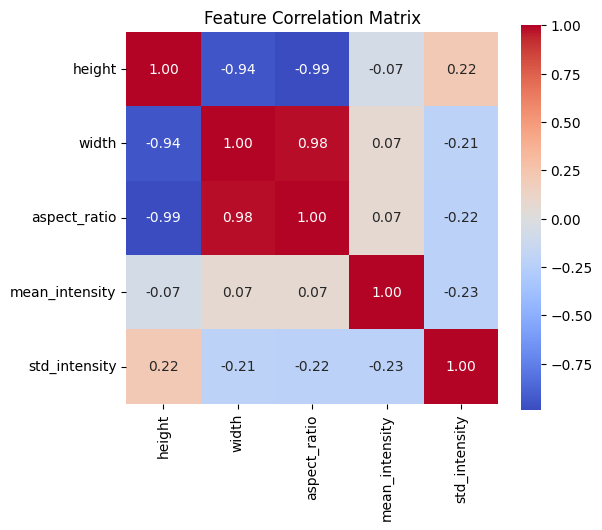

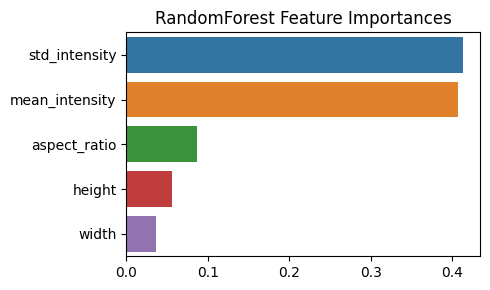

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assume df already exists with columns:
# ['class','height','width','aspect_ratio','mean_intensity','std_intensity']

### 1. OUTLIER DETECTION

# 1a) IQR method
def iqr_outliers(series):
    q1, q3 = np.percentile(series, [25,75])
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    return series[(series < low) | (series > high)]

print("=== IQR Outliers ===")
for feat in ['height','width','aspect_ratio','mean_intensity','std_intensity']:
    out = iqr_outliers(df[feat])
    print(f"{feat:15s}: {len(out)} outliers")

# 1b) Z‑score method (threshold = 3)
z = np.abs(stats.zscore(df[['height','width','aspect_ratio',
                             'mean_intensity','std_intensity']]))
z_feats = dict(zip(df.columns[1:6], (z>3).sum(axis=0)))
print("\n=== Z‑score Outliers (>3σ) ===")
for feat,count in z_feats.items():
    print(f"{feat:15s}: {count}")

# 1c) IsolationForest
iso = IsolationForest(contamination=0.01, random_state=42)
df['anomaly'] = iso.fit_predict(df[['height','width',
                                    'aspect_ratio','mean_intensity']])
n_iso = (df['anomaly']==-1).sum()
print(f"\n=== IsolationForest Outliers ({n_iso} flagged) ===")

### 2. CORRELATION MATRIX

plt.figure(figsize=(6,5))
corr = df[['height','width','aspect_ratio',
           'mean_intensity','std_intensity']].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Feature Correlation Matrix")
plt.show()

### 3. FEATURE IMPORTANCE VIA RANDOM FOREST

# Encode classes numerically
df['cls_id'] = df['class'].astype('category').cat.codes

# Prepare X, y
X = df[['height','width','aspect_ratio',
        'mean_intensity','std_intensity']]
y = df['cls_id']

# Standardize features
X_scaled = StandardScaler().fit_transform(X)

# Fit RandomForest
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rfc.fit(X_scaled, y)

# Extract and plot importances
importances = pd.Series(rfc.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(5,3))
sns.barplot(x=importances.values, y=importances.index)
plt.title("RandomForest Feature Importances")
plt.tight_layout()
plt.show()


In [6]:
from sklearn.ensemble import IsolationForest

features = ['height','width','aspect_ratio','mean_intensity','std_intensity']
iso = IsolationForest(contamination=0.01, random_state=42)
df['anomaly'] = iso.fit_predict(df[features])   # fit & predict on same named slice
print("IsolationForest outliers (‑1):", (df['anomaly']==-1).sum())


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest outliers (‑1): 156


                  height     width  aspect_ratio  mean_intensity  \
height          1.000000 -0.944668     -0.990382       -0.066624   
width          -0.944668  1.000000      0.978426        0.067958   
aspect_ratio   -0.990382  0.978426      1.000000        0.067742   
mean_intensity -0.066624  0.067958      0.067742        1.000000   
std_intensity   0.218290 -0.213149     -0.221006       -0.225445   

                std_intensity  
height               0.218290  
width               -0.213149  
aspect_ratio        -0.221006  
mean_intensity      -0.225445  
std_intensity        1.000000  


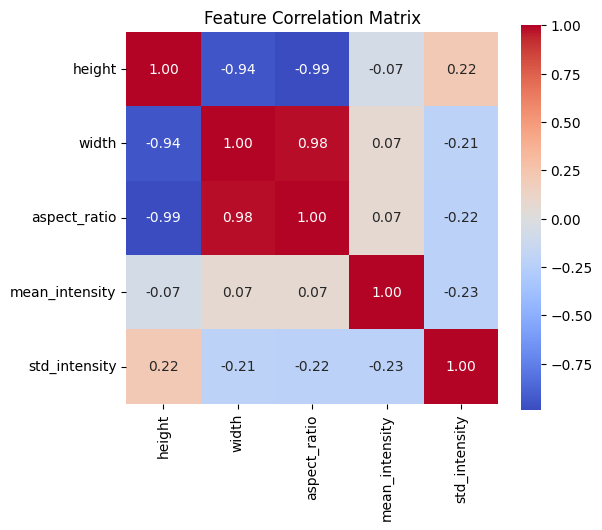

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 2a) Print the correlation DataFrame
corr = df[features].corr()
print(corr)

# 2b) Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", square=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


Feature importances:
                 importance
std_intensity     0.413499
mean_intensity    0.407470
aspect_ratio      0.087003
height            0.055736
width             0.036292


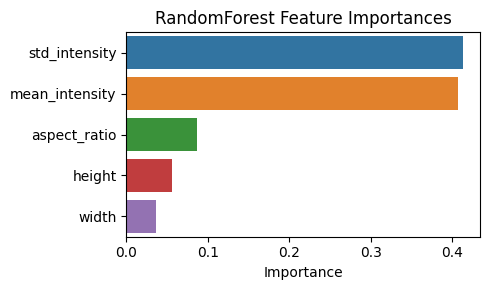

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# 3a) Encode classes
df['cls_id'] = df['class'].astype('category').cat.codes

# 3b) Prepare X, y
X = df[features]
y = df['cls_id']

# 3c) Standardize
X_scaled = StandardScaler().fit_transform(X)

# 3d) Train RF (use all cores)
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rfc.fit(X_scaled, y)

# 3e) Extract & print raw importances
importances = pd.Series(rfc.feature_importances_, index=features)
importances = importances.sort_values(ascending=False)
print("Feature importances:\n", importances.to_frame(name='importance'))

# 3f) Plot
plt.figure(figsize=(5,3))
sns.barplot(x=importances.values, y=importances.index)
plt.title("RandomForest Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [9]:
df[df['anomaly']==-1]['class'].value_counts().head(10)
# to see which features are most prone to anomalies

class
Warts Molluscum and other Viral Infections               16
Systemic Disease                                         14
Acne and Rosacea Photos                                  13
Lupus and other Connective Tissue diseases               10
Exanthems and Drug Eruptions                              9
Light Diseases and Disorders of Pigmentation              8
Hair Loss Photos Alopecia and other Hair Diseases         8
Nail Fungus and other Nail Disease                        8
Vasculitis Photos                                         8
Psoriasis pictures Lichen Planus and related diseases     8
Name: count, dtype: int64

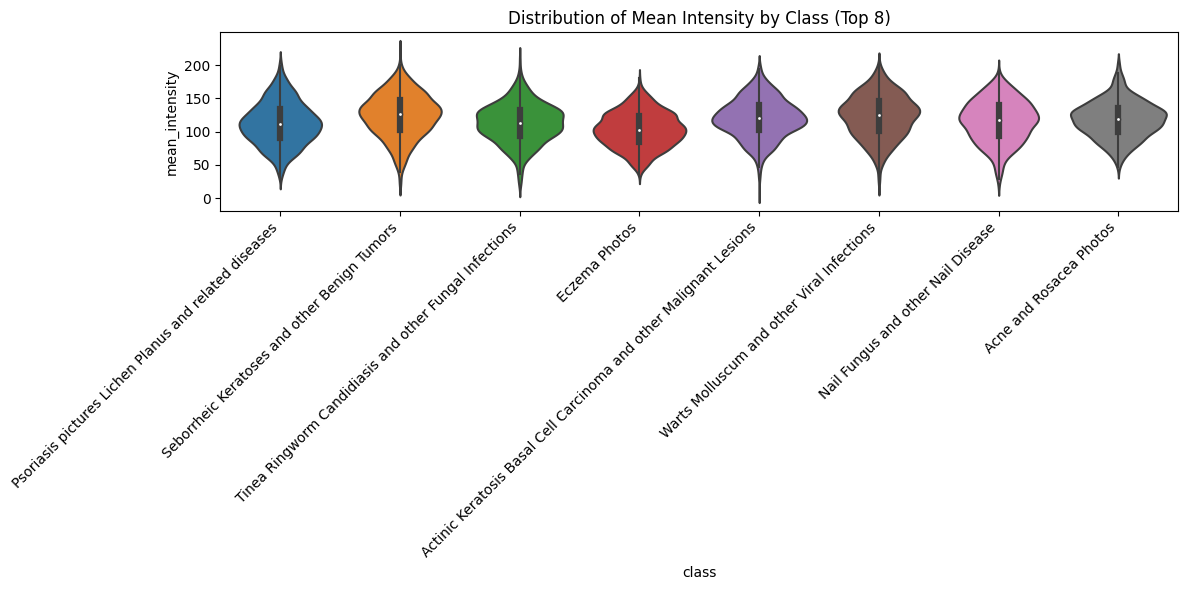

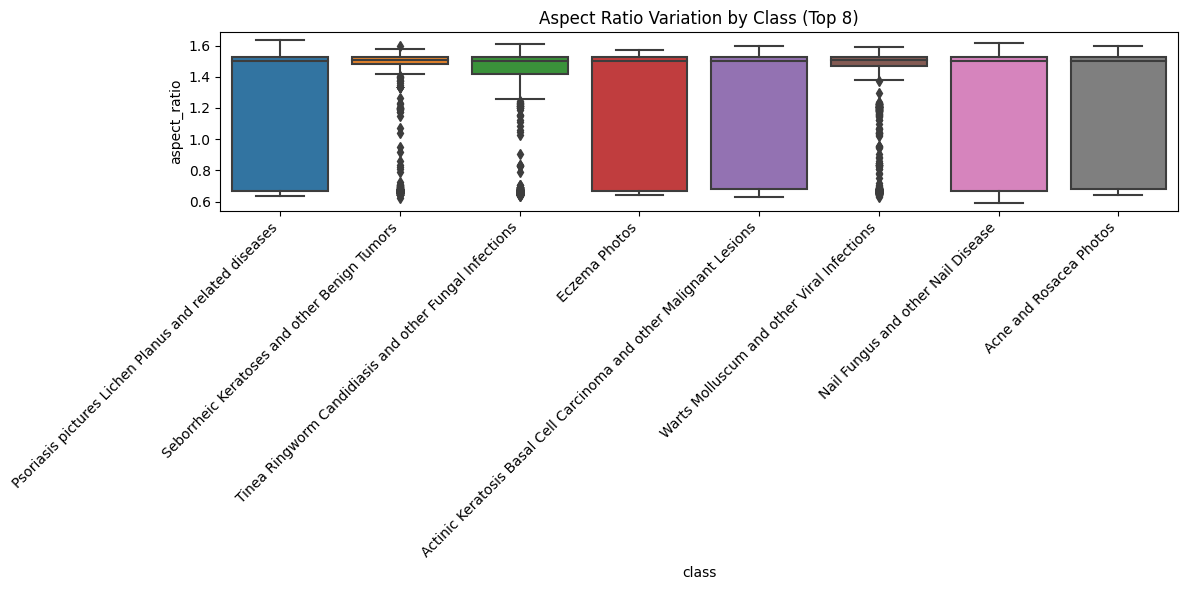

In [11]:
# feature distribution by class (of a sample of 8)
import matplotlib.pyplot as plt
import seaborn as sns

# Pick a small subset of classes (e.g. top 8 by count) for readability
top8 = df['class'].value_counts().index[:8]
df8 = df[df['class'].isin(top8)]

# Violin plots
plt.figure(figsize=(12,6))
sns.violinplot(x='class', y='mean_intensity', data=df8, order=top8)
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of Mean Intensity by Class (Top 8)")
plt.tight_layout()
plt.show()

# Box plots for aspect ratio
plt.figure(figsize=(12,6))
sns.boxplot(x='class', y='aspect_ratio', data=df8, order=top8)
plt.xticks(rotation=45, ha='right')
plt.title("Aspect Ratio Variation by Class (Top 8)")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

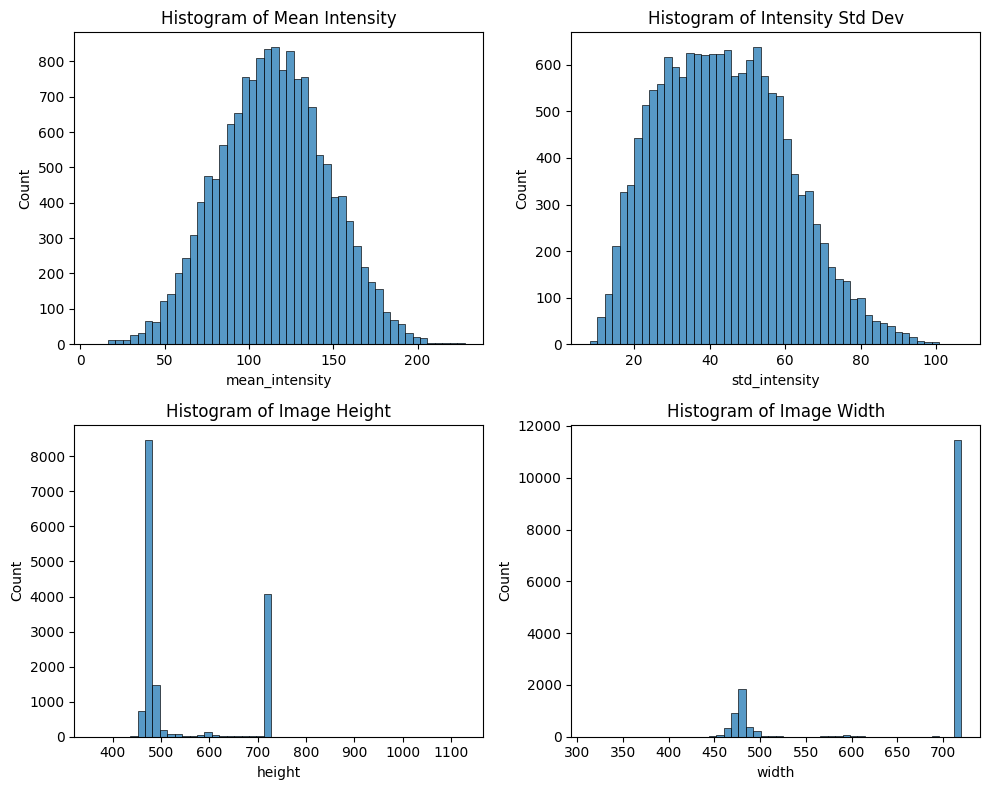

In [13]:
# Histogram of Pixel‐Intensity & Size
fig, axes = plt.subplots(2,2, figsize=(10,8))

sns.histplot(df['mean_intensity'], bins=50, ax=axes[0,0])
axes[0,0].set_title("Histogram of Mean Intensity")

sns.histplot(df['std_intensity'], bins=50, ax=axes[0,1])
axes[0,1].set_title("Histogram of Intensity Std Dev")

sns.histplot(df['height'], bins=50, ax=axes[1,0])
axes[1,0].set_title("Histogram of Image Height")

sns.histplot(df['width'], bins=50, ax=axes[1,1])
axes[1,1].set_title("Histogram of Image Width")

plt.tight_layout()
plt.show()


/tmp/ipykernel_35/1141688088.py:21: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


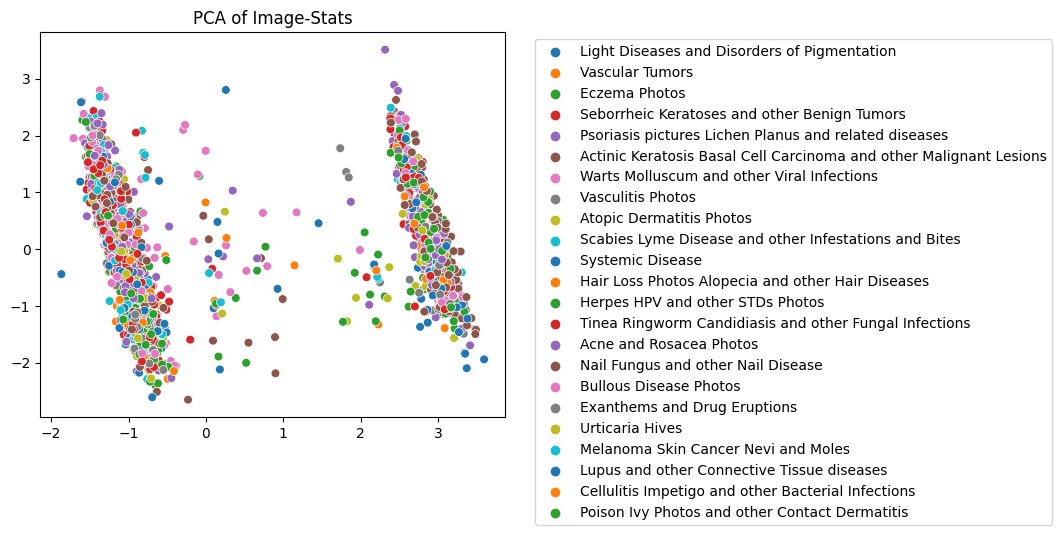

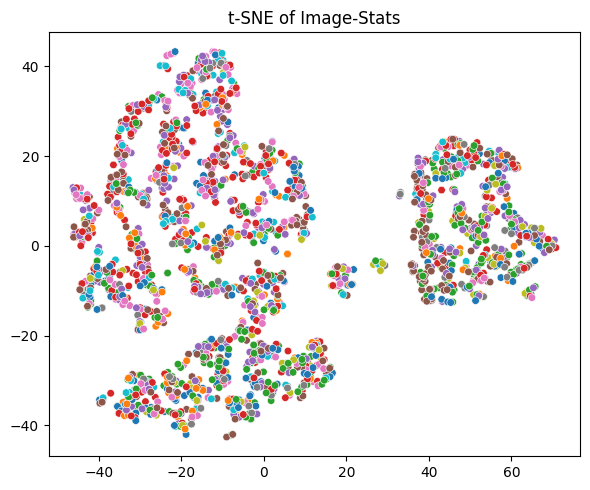

In [14]:
#PCA / t‑SNE Embedding of Summary Stats
# Visualize how classes cluster in 2D—you can identify which lesions are easily separable vs. overlapping.
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Sample for speed
sample = df.sample(n=2000, random_state=42)
X = sample[['height','width','aspect_ratio','mean_intensity','std_intensity']]
y = sample['class'].astype('category').cat.codes
labels = sample['class'].astype('category').cat.categories

# 3a) PCA
pca = PCA(n_components=2, random_state=42)
Z_pca = pca.fit_transform(StandardScaler().fit_transform(X))

plt.figure(figsize=(6,5))
sns.scatterplot(x=Z_pca[:,0], y=Z_pca[:,1], hue=sample['class'],
                palette='tab10', legend='brief', s=40)
plt.title("PCA of Image‐Stats")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', ncol=1)
plt.tight_layout()
plt.show()

# 3b) t‑SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
Z_tsne = tsne.fit_transform(StandardScaler().fit_transform(X))

plt.figure(figsize=(6,5))
sns.scatterplot(x=Z_tsne[:,0], y=Z_tsne[:,1], hue=sample['class'],
                palette='tab10', legend=False, s=30)
plt.title("t‑SNE of Image‐Stats")
plt.tight_layout()
plt.show()


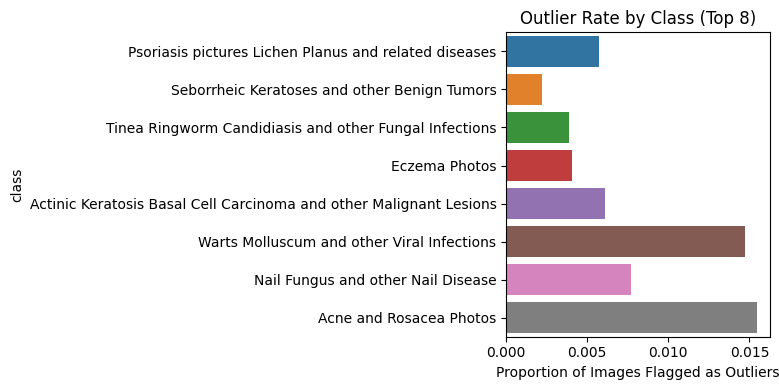

In [15]:
# Outlier Rate by Class
# Assume df['anomaly'] (-1 for outlier, 1 for normal)
out_rates = (
    df
    .groupby('class')['anomaly']
    .apply(lambda x: (x==-1).mean())
    .sort_values(ascending=False)
    .loc[top8]  # top 8 for readability
)

plt.figure(figsize=(8,4))
sns.barplot(x=out_rates.values, y=out_rates.index)
plt.xlabel("Proportion of Images Flagged as Outliers")
plt.title("Outlier Rate by Class (Top 8)")
plt.tight_layout()
plt.show()
